In [1]:
import numpy as np
import math
import ceo
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
D = 25.5;
n = 16
nLenslet =30
nPx = n*nLenslet + 1 ;
src    = ceo.Source("R",zenith=0*math.pi/180/3600,azimuth=0*math.pi/4,
                    rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,-25])
imgr = ceo.ShackHartmann(1, nPx-1, D ,DFT_osf=2,N_PX_IMAGE=nPx)
wfs = ceo.ShackHartmann(nLenslet, n, D/nLenslet,N_PX_IMAGE=2*n)
M1 = ceo.GMT_M1(D,nPx)
M2 = ceo.GMT_M2(D,nPx)

In [3]:
#M1.reset()
#M1.global_tiptilt(5*math.pi/180,0.*math.pi/180.0/3600)

In [4]:
def optical_system(x,radius):
    src.stop(M2)
    src.trace(M1)
    src.trace(M2)
    src.rays.go_sphere(x,radius)
    src.opd2phase()

In [5]:
def opd_res_fun(x,radius):
    src.reset()
    optical_system(x,radius)
    opd = src.rays.optical_path_difference.host()
    opd_res = ( opd[0,:] )*1e9
    P = src.rays.vignetting.host()
    return np.std(opd_res[P.ravel(0)>0])

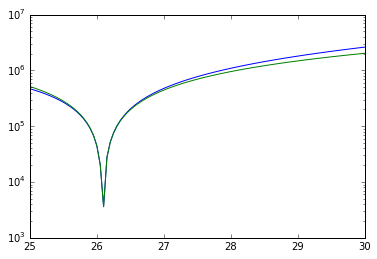

In [6]:
x = linspace(25,30,101)
#plot(x,[opd_fun(_x_,1) for _x_ in x])
semilogy(x,[opd_res_fun(_x_,10) for _x_ in x])
#plot(x,[opd_fun(_x_,10) for _x_ in x])
semilogy(x,[opd_res_fun(_x_,50) for _x_ in x])

In [7]:
from scipy.optimize import minimize_scalar
#print opd_fun(5.83001949259)
sphere_radius = 50
#res = minimize_scalar(opd_fun, bounds=(26.09249-b,26.09249+b), method='bounded')
res = minimize_scalar(opd_res_fun, bounds=(25,30), method='bounded',args=(sphere_radius,))
print res.success
print res.x
chief_xyz = src.rays.chief_coordinates.host() - sphere_radius*src.rays.chief_directions.host()
print "Minimum wfe rms focus @ [%6.4f,%6.4f,%6.4f]m with rms wfe=%6.4fnm"%(chief_xyz[0,0],chief_xyz[0,1],chief_xyz[0,2],opd_res_fun(res.x,sphere_radius))

True
26.0924944466
Minimum wfe rms focus @ [-0.0000,-0.0000,-5.8300]m with rms wfe=1.3657nm


In [8]:
src.reset()
optical_system(res.x,sphere_radius)
imgr.calibrate(src,0.0)
wfs.calibrate(src,0.75)

<matplotlib.colorbar.Colorbar instance at 0x2b1f67b24bd8>

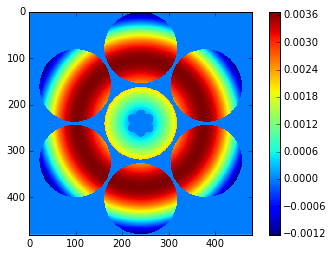

In [9]:
src.reset()
M1.reset()
M2.reset()
optical_system(res.x,sphere_radius)
opl0 = src.rays.optical_path_length.host()*1e6
opd0 = src.rays.optical_path_difference.host()*1e6
figure
imshow(np.reshape(opd0,(nPx,nPx)),interpolation='none')
colorbar()

In [10]:
print src.wavefront.rms()

[  1.36566314e-09]


0.621221063194


<matplotlib.colorbar.Colorbar instance at 0x2b1f67cbd680>

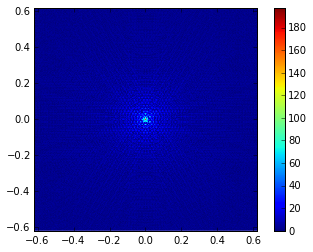

In [11]:
imgr.analyze(src)
lim = (nPx-1)/2*imgr.pixel_scale_arcsec
print lim
imshow(imgr.frame.host()**0.25,interpolation='none',extent=[-lim,lim,-lim,lim],origin='lower')
colorbar()

<matplotlib.colorbar.Colorbar instance at 0x2b1f6ce130e0>

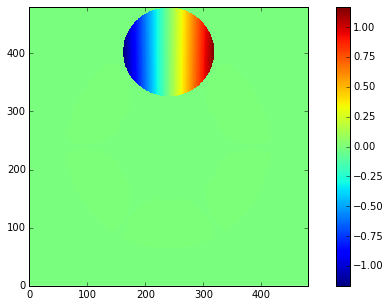

In [21]:
src.reset()
M1.reset()
M2.reset()
x_tt = 0.0
y_tt = 0.03
c = math.pi/180/3600.0
M1.update(origin=[0,0,0],euler_angles=[x_tt*c,y_tt*c,0],idx=1)
optical_system(res.x,sphere_radius)
opl_loc = src.rays.optical_path_length.host()*1e6
opd_loc = src.rays.optical_path_difference.host()*1e6
fig, ax2 = subplots(ncols=1)
fig.set_size_inches(10,5)
h2 = ax2.imshow(np.reshape(opd_loc,(nPx,nPx)),interpolation='none',origin='lower')
colorbar(h2)

<matplotlib.colorbar.Colorbar instance at 0x2b1f6cf7b680>

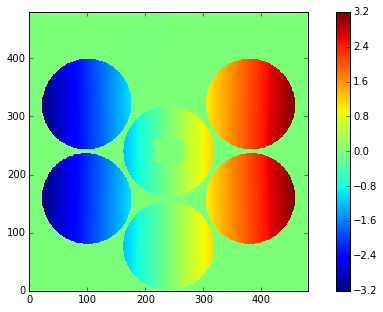

In [22]:
src.reset()
M1.reset()
M2.reset()
M1.global_tiptilt(x_tt*c,y_tt*c)
optical_system(res.x,sphere_radius)
opl_glb = src.rays.optical_path_length.host()*1e6
opd_glb = src.rays.optical_path_difference.host()*1e6
fig, ax2 = subplots(ncols=1)
fig.set_size_inches(10,5)
h2 = ax2.imshow(np.reshape(opd_glb-opd_loc,(nPx,nPx)),interpolation='none',origin='lower')
colorbar(h2)

In [14]:
print c/2

2.42406840555e-06


IMGR pixel scale  2.59 mas
IMGR pixel scale 1245.03 mas
0.310610531597


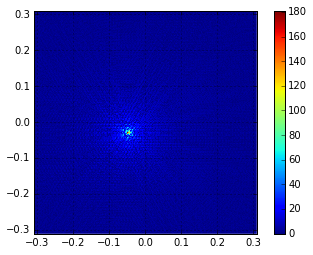

In [15]:
imgr.reset()
imgr.analyze(src)
print 'IMGR pixel scale %5.2f mas'%(imgr.pixel_scale_arcsec*1e3)
print 'IMGR pixel scale %5.2f mas'%(imgr.pixel_scale_arcsec*1e3*nPx)
lim = (nPx-1)/2*imgr.pixel_scale_arcsec/2
print lim
imshow(imgr.frame.host()**0.25,interpolation='none',extent=[-lim,lim,-lim,lim],origin='lower')
colorbar()
grid()

In [16]:
print imgr.c.host(units='arcsec')*1e3

[[-56.86766052 -94.77726746]]


WFS pixel scale 77.65 mas
WFS pixel scale 2484.88 mas


<matplotlib.colorbar.Colorbar instance at 0x2aed1da64f38>

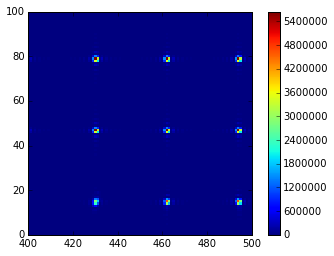

In [17]:
wfs.reset()
wfs.analyze(src)
print 'WFS pixel scale %5.2f mas'%(wfs.pixel_scale_arcsec*1e3)
print 'WFS pixel scale %5.2f mas'%(wfs.pixel_scale_arcsec*1e3*n*2)
imshow(wfs.frame.host(),interpolation='none',origin='lower')
axis([400,500,0,100])
colorbar()

<matplotlib.colorbar.Colorbar instance at 0x2aed1d8c6a70>

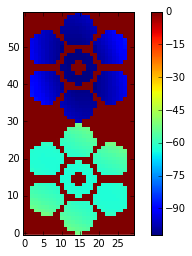

In [18]:
imshow(1e3*wfs.c.host(units='arcsec').reshape(2*nLenslet
                                    ,nLenslet),interpolation='none',origin='lower')
colorbar()